<a href="https://colab.research.google.com/github/Hirakhan15/PCOs/blob/main/ResNet50(pcos).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import glob
import zipfile

In [36]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
# Adjust ROOT_DIR to point to your Google Drive folder (assuming 'PCOS' is in My Drive with subfolders 'infected' and 'notinfected')
# If your dataset is already in '/content/PCOS', keep as is; otherwise, update to avoid file issues
ROOT_DIR = '/content/drive/MyDrive/PCOS'  # Updated for safety—original was '/content/PCOS'

In [38]:
number_of_images = {}

In [39]:
for dir in os.listdir(ROOT_DIR):
   number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR,dir)))
   print("",dir,"" ,number_of_images[dir])


 infected  6784
 noninfected  5000


In [40]:

# Import ResNet50-specific modules (changed from MobileNet)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input  # Changed to ResNet50 preprocess

In [41]:
def preprocessingImage1(path):
  image_data = ImageDataGenerator(zoom_range=0.2,shear_range=0.2,preprocessing_function=preprocess_input,horizontal_flip=True)  # Use ResNet50 preprocess
  image = image_data.flow_from_directory(directory=path,target_size=(224,224),batch_size=32,class_mode='binary')
  return image


def preprocessionfImage2(path):
  """
  Input :path
  Output : preprocessed Image
  """
  image_data  = ImageDataGenerator(preprocessing_function=preprocess_input)  # Use ResNet50 preprocess
  image = image_data.flow_from_directory(directory=path,target_size=(224,224),batch_size=32,class_mode='binary')

  return image


In [42]:
def datafolder(path,split):
  if not os.path.exists("./"+path):
    os.mkdir("./"+path)

    for dir in os.listdir(ROOT_DIR):
      os.makedirs("./"+path+"/"+dir)
      for img in np.random.choice(a=os.listdir(os.path.join(ROOT_DIR,dir)),
                                  size=(math.floor(split * number_of_images[dir])-5),replace=False):

          O = os.path.join(ROOT_DIR,dir,img)
          D = os.path.join("./"+path,dir)
          shutil.copy(O,D)
          # os.remove(O)  # Commented out to avoid deleting originals—copy instead of move for safety

  else:
     print("Folder already exist")

In [43]:
datafolder("train",0.7)


Folder already exist


In [44]:


datafolder("val",0.15)

Folder already exist


In [45]:
datafolder("test",0.15)

Folder already exist


In [46]:

path ='/content/train'
train_data = preprocessingImage1(path)

Found 8238 images belonging to 2 classes.


In [47]:
path ='/content/test'
test_data = preprocessionfImage2(path)


Found 1757 images belonging to 2 classes.


In [48]:

path = '/content/val'
val_data = preprocessionfImage2(path)


Found 1757 images belonging to 2 classes.


In [49]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Flatten,Dense
from keras.models import Model,load_model
# Changed to ResNet50 import
from keras.applications.resnet50 import ResNet50
import keras

In [50]:
# Changed base_model to ResNet50
base_model = ResNet50(input_shape=(224,224,3), weights='imagenet', include_top=False)

In [51]:

for layer in base_model.layers:
  layer.trainable = False

In [52]:

x= Flatten()(base_model.output)
x= Dense(units=1,activation='sigmoid')(x)


In [53]:

model = Model(base_model.input,x)

In [54]:

model.compile(optimizer='rmsprop',loss=keras.losses.binary_crossentropy,metrics=['accuracy'])

In [55]:

from keras.callbacks import ModelCheckpoint,EarlyStopping

In [56]:

mc = ModelCheckpoint(filepath="bestmodel.h5",monitor='val_accuracy',verbose=1,save_best_only=True)

#Early check points
es = EarlyStopping(monitor="val_accuracy",min_delta=0.01,patience=5,verbose=1)

cb = [mc,es]


In [57]:
# Note: class_weights is used here but not defined in the original code. Define it if imbalanced (e.g., class_weights = {0: 1.0, 1: 1.5} based on your classes)
# Assuming 'infected' is class 0 (Affected), 'notinfected' is class 1 (Not Affected)—calculate properly if needed
# For now, commenting out class_weight if not defined; add if necessary
hist = model.fit(
    train_data,
    epochs=15,
    validation_data=val_data,
    callbacks=cb,
    # class_weight=class_weights  # Uncomment and define class_weights if needed
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.8780 - loss: 2.8481
Epoch 1: val_accuracy improved from -inf to 0.98293, saving model to bestmodel.h5


258/258 ━━━━━━━━━━━━━━━━━━━━ 136s 489ms/step - accuracy: 0.8782 - loss: 2.8432 - val_accuracy: 0.9829 - val_loss: 0.3363
Epoch 2/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.9634 - loss: 0.8239
Epoch 2: val_accuracy improved from 0.98293 to 0.99203, saving model to bestmodel.h5


258/258 ━━━━━━━━━━━━━━━━━━━━ 118s 457ms/step - accuracy: 0.9634 - loss: 0.8238 - val_accuracy: 0.9920 - val_loss: 0.2236
Epoch 3/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.9666 - loss: 0.7723
Epoch 3: val_accuracy did not improve from 0.99203
258/258 ━━━━━━━━━━━━━━━━━━━━ 115s 446ms/step - accuracy: 0.9667 - loss: 0.7717 - val_accuracy: 0.9829 - val_loss: 0.5292
Epoch 4/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.9776 - loss: 0.5255
Epoch 4: val_accuracy did not improve from 0.99203
258/258 ━━━━━━━━━━━━━━━━━━━━ 116s 448ms/step - accuracy: 0.9776 - loss: 0.5255 - val_accuracy: 0.9664 - val_loss: 0.8680
Epoch 5/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.9812 - loss: 0.3894
Epoch 5: val_accuracy did not improve from 0.99203
258/258 ━━━━━━━━━━━━━━━━━━━━ 116s 451ms/step - accuracy: 0.9812 - loss: 0.3895 - val_accuracy: 0.9209 - val_loss: 2.9772
Epoch 6/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.9831 - loss: 0.3463
Epoch 6: va

In [58]:
model = load_model("/content/bestmodel.h5")

In [59]:
acc = model.evaluate(test_data)[1]
print(f"our model accuracy is  {acc * 100} %")

55/55 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9947 - loss: 0.1306
our model accuracy is  99.31702017784119 %


In [60]:

h = hist.history
h.keys()


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [61]:
train_data.class_indices

{'infected': 0, 'noninfected': 1}

In [62]:
test_data.class_indices

{'infected': 0, 'noninfected': 1}

In [63]:

val_data.class_indices

{'infected': 0, 'noninfected': 1}

In [64]:
#now get some random images and predict the class
from keras.preprocessing import image
import tensorflow as tf


In [65]:
from tensorflow.keras.applications.resnet50 import preprocess_input  # Ensure this is imported at the top

def predictimage(path):
    img = tf.keras.utils.load_img(path, target_size=(224, 224))
    i = tf.keras.utils.img_to_array(img)
    i = preprocess_input(i)  # Fix: Apply ResNet50-specific normalization
    input_arr = np.array([i])

    pred_prob = model.predict(input_arr)[0][0]  # Get scalar probability
    print(f"Raw Probability: {pred_prob:.4f}")  # Debug: Should be >0.5 for 'notinfected' if class 1

    # Adjust based on your class_indices (check below)
    if pred_prob >= 0.5:
        print("Not Affected")  # Assuming {'infected':0, 'notinfected':1}
    else:
        print("Affected")

    # Display original image (preprocessing alters it)
    plt.imshow(tf.keras.utils.img_to_array(img) / 255.0)
    plt.title("Input Image")
    plt.show()


Saving img_0_492.jpg to img_0_492.jpg
Uploaded file path: /content/img_0_492.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Raw Probability: 0.0000
Affected


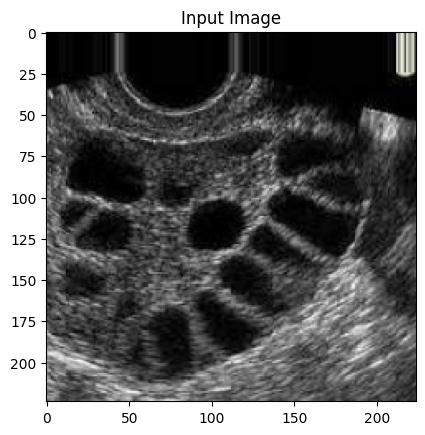

In [68]:
# Step 1: Upload image from your laptop
from google.colab import files
uploaded = files.upload()

# Step 2: Get the uploaded file name
import os
for fn in uploaded.keys():
    file_path = os.path.join("/content", fn)
    print("Uploaded file path:", file_path)

    # Step 3: Run prediction on the uploaded image
    predictimage(file_path)
